# Compute the iron sediment forcing (`fedsedflux`) supplied to the model

This notebook implements an approach to computing `fesedflux` originally in a IDL routine by J. K. Moore.

`fesedflux` includes two components, oxic (`fesedflux_oxic`) and reducing `fesedflux_reduce` sediment sources.

`fesedflux_oxic`: a constant low background value; increased in regions of high bottom horizontal current speed (sediment resuspenion) by up to a factor of 100.

`fesedflux_reduce`: source everywhere linearly related to the sinking POC flux by `coef_fesedflux_POC_flux`; source is zero below `POC_flux_gCm2yr_min` (3 gC m$^{-2}$ yr$^{-1}$ in CESM2) and constant above a maximum `POC_flux` (`POC_flux_gCm2yr_max`). This puts a source on the shelf, and along productive slope/margins, but has little source in the deep ocean.

`fesedflux` is computed on subgrid-scale bathymetry, using the fraction of each cell that is ocean bottom at each depth: `fesedfrac`. `fesedfrac` is [computed from ETOPO1 bathymetry](sedfrac_compute.ipynb).

**`fesedflux_reduce` is subject to conditional modification:**
- a maximum iron flux (implemented as max. sink POC flux)
- a minimum percentage of each grid cell that is sediments (`land_adj_sedfrac_min`) for all land-adjacent grid cells
- `fesedflux_reduce = 0` where POC flux is less < 3 gC m$^{-2}$ yr$^{-1}$; this is the deep ocean, where almost all the remineralization is oxic right on the sediment surface.


**Arbitrary modification to this objective scheme:**
- `fesedflux_reduce` is multiplied by 10 in the western equatorial Pacific (135-200E, 15S-15N, above 504 m). 


## Procedure

1. Prepare `fesedfrac`:
   - Read pre-computed [`fesedfrac`](sedfrac_compute.ipynb);
   - Determine land-adjascent points;
   - Create `sedfrac_mod` by applying `land_adj_sedfrac_min`.


2. Compute `fesedflux_reduce`:
   - Read `POC_flux` and convert units; 
   - Where `POC_flux < POC_flux_gCm2yr_min, POC_flux = 0.`;
   - Where `POC_flux > POC_flux_gCm2yr_max, POC_flux = POC_flux_gCm2yr_max`
   - `fesedflux_reduce = POC_flux * coef_fesedflux_POC_flux * sedfrac_mod`
   - Apply ad hoc scaling in to select regions.


3. Compute `fesedflux_oxic`:
   - Read `UVEL` and `VVEL` and compute `current_speed`
   - Where `current_speed < 1.0: current_speed = 1.0`
   - Where `current_speed > 10.0: current_speed = 10.0` 
   - `fesedflux_oxic = coef_fesedflux_current_speed * sedfrac * current_speed**2`
   

4. Output `fesedflux_oxic` and `fesedflux_reduce` in model units: µmol/m^2/d
   

## Preliminary setup

In [1]:
%matplotlib inline
import os
import tqdm
import yaml
from itertools import product

from datetime import date, datetime, timezone

import numpy as np
import xarray as xr
import scipy.sparse as sps

import esmlab

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import config

In [2]:
id_string = 'Fe_sediment_flux_forcing.ipynb from github.com/marbl-ecosys/marbl-forcing/Fe_sediment_flux'

mol_per_nmol = 1e-9 
mol_per_µmol = 1e-6
mol_per_mmol = 1e-3
mol_per_Gmol = 1e9
gC_per_mol = 12.011 
cm2_per_m2 = 1e4 
d_per_yr = 365.0
s_per_yr = d_per_yr * 86400.0
nmolCcm2s_to_gCm2yr = mol_per_nmol * gC_per_mol * cm2_per_m2 * s_per_yr
mmolCm2d_to_gCm2yr = mol_per_mmol * gC_per_mol * d_per_yr
mmolm2yr_to_µmolm2d = 1. / d_per_yr / mol_per_µmol * mol_per_mmol

### Specify model grid

In [3]:
dst_grid = 'POP_gx1v7'

POC_flux_gCm2yr_max = 20.
POC_flux_gCm2yr_min = 3.

current_speed_min = 1.   # cm/s
current_speed_max = 10.  # cm/s

western_pacific_factor = 10. # scale Fe flux in W. Pacific

if dst_grid == 'POP_gx1v7':    
    land_adj_sedfrac_min = 0.03
    coef_fesedflux_POC_flux = 0.01614 * 1.6 # (mmolFe/m^2/yr)/(gC/m^2/yr)
    coef_fesedflux_current_speed2 = 0.0006568 * 1.2
    
elif dst_grid == 'POP_gx3v7':
    land_adj_sedfrac_min = 0.015
    coef_fesedflux_POC_flux = 0.01584 # (mmolFe/m^2/yr)/(gC/m^2/yr)
    coef_fesedflux_current_speed2 = 0.0008405
    
elif dst_grid == 'POP_tx0.1v3':
    land_adj_sedfrac_min = 0.03
    coef_fesedflux_POC_flux = 0.01614 # (mmolFe/m^2/yr)/(gC/m^2/yr)
    coef_fesedflux_current_speed2 = 0.0006568


### Get model data `POC_FLUX_IN`, `UVEL`, `VVEL`, `KMT`

#### Identify model input

In [4]:
case = 'b.e21.B1850.f09_g17.CMIP6-piControl.001'
droot = f'/glade/collections/cdg/timeseries-cmip6/{case}'
droot = f'{droot}/ocn/proc/tseries/month_1'
datestr = '060001-069912'
src_grid = 'POP_gx1v7'
variables = ['POC_FLUX_IN', 'UVEL', 'VVEL']

fesedflux_input_file = f'{config.dirwork}/{case}.fesedflux_input.{datestr}-mean.{dst_grid}.nc'
fesedflux_input_file

'/glade/work/mclong/cesm_inputdata/work/b.e21.B1850.f09_g17.CMIP6-piControl.001.fesedflux_input.060001-069912-mean.POP_gx1v7.nc'

Read model output and save input file; if input file exists, just read it.

In [5]:
if not os.path.exists(fesedflux_input_file):
    
    import ncar_jobqueue
    import dask
    import dask.distributed

    cluster = ncar_jobqueue.NCARCluster(walltime='12:00:00')
    client = dask.distributed.Client(cluster)
    n_workers = 9 * 4
    cluster.scale(n_workers)
    
    print(client)
        
    input_file_list = []
    ds = xr.Dataset()
    for v in variables:
        file_in = f'{droot}/{case}.pop.h.{v}.{datestr}.nc'
        assert os.path.exists(file_in), f'Missing {file_in}'
        
        input_file_list.append(file_in)
        print(f'reading {v}: {file_in}')

        dsv = xr.open_dataset(file_in, decode_times=False, 
                              decode_coords=False, chunks={'time': 24, 'z_t': 20})
        ds = xr.merge((ds, dsv))

    print('dropping variables')
    ds = ds.drop([v for v in ds.variables if v not in variables+['TAREA', 'KMT', 'TLONG', 'TLAT', 'z_t', 'time', 'time_bound']])
    
    #-- compute long-term mean
    print('computing mean')
    with xr.set_options(keep_attrs=True):
        ds = esmlab.resample(ds, freq='ann').mean('time').compute()

    #-- write inputfile
    print(f'writing {fesedflux_input_file}')
    
    ds.attrs['input_file_list'] = ' '.join(input_file_list)
    
    ds.to_netcdf(fesedflux_input_file)
    
    cluster.close()
    client.close()

else:
    print(f'reading {fesedflux_input_file}')
    ds = xr.open_dataset(fesedflux_input_file, decode_times=False, decode_coords=False).compute()
    input_file_list = ds.attrs['input_file_list'].split(' ')
ds    

reading /glade/work/mclong/cesm_inputdata/work/b.e21.B1850.f09_g17.CMIP6-piControl.001.fesedflux_input.060001-069912-mean.POP_gx1v7.nc


<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (d2) float64 2.371e+05 2.374e+05
    POC_FLUX_IN  (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    UVEL         (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    VVEL         (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    KMT          (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
Attributes:
    history:          \n2019-05-20 11:42:54.999702 esmlab.resample(<DATASET>,...
    input_file_list:  /glade/collections/cdg/timeseries-cmip6/b.e21.B1850.f09...

### Regrid if necessary

In [6]:
if src_grid != dst_grid:
    raise NotImplementedError('regridding not yet implemented')

## Prepare `fesedfrac`

### Read pre-computed [`fesedfrac`](sedfrac_compute.ipynb)

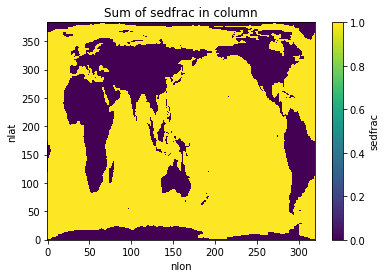

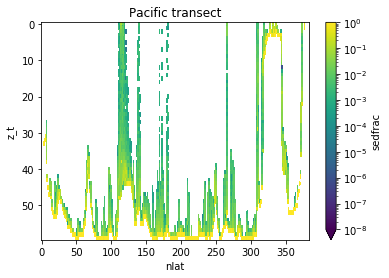

In [7]:
with xr.open_dataset(config.sedfrac_file(dst_grid)) as dstmp:
    sedfrac = dstmp.sedfrac.compute()
    
np.testing.assert_allclose(sedfrac.z_t.data, ds.z_t.data)
sedfrac = sedfrac.reset_index('z_t', drop=True)

sedfrac = sedfrac.where(ds.KMT > 0).fillna(0.)
sedfrac.sum('z_t').plot()
h = plt.title('Sum of sedfrac in column')

plt.figure()
sedfrac.isel(nlon=200).plot(yincrease=False, norm=colors.LogNorm(vmin=1e-8, vmax=1.))
h = plt.title('Pacific transect')

### Determine land-adjacent points and apply `land_adj_sedfrac_min`

#### Compute a 3D topography mask
Now we'll compute the 3D volume field, masked appropriate by the topography.

First step is to create the land mask.

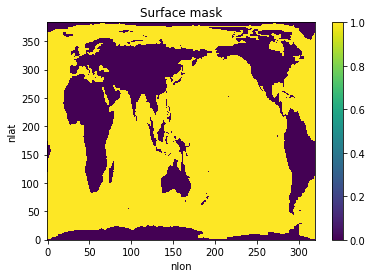

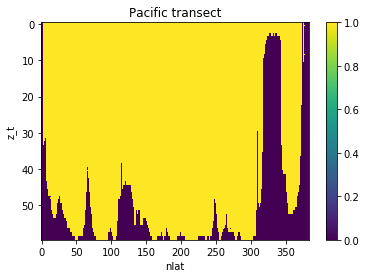

In [8]:
nk = len(ds.z_t)
nj, ni = ds.KMT.shape

# make 3D array of 0:km
zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
ZERO_TO_KM = (zero_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds.KMT)
MASK = xr.where(MASK.notnull(), 1., 0.)

plt.figure()
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=200).plot(yincrease=False)
h = plt.title('Pacific transect')

Construct an array of `KMT` at all eight adjoining grid cells. `xarray.DataArray.roll` shifts the data periodically. For the `lon` direction, the domain is periodic, so this is appropriate. Our Greenland-pole grids have land at both northern and southern part of the logical domain, so no special treament is required. The tri-pole grids, however, require special treatment in the logical north.

Land-adjacent points = 1.; Ocean = 2.; Land = 0.


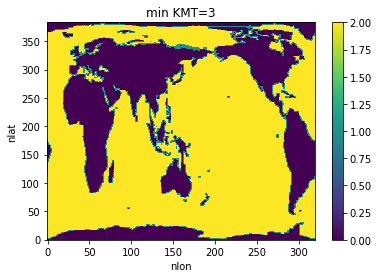

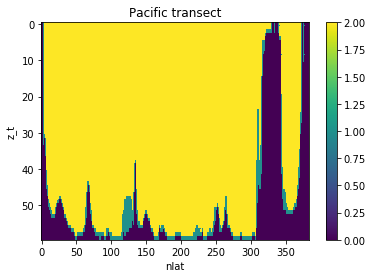

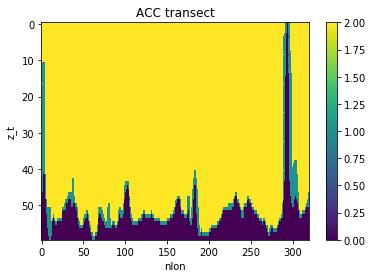

In [9]:
kmt_neighbors = xr.DataArray(np.empty((nj, ni, 8)), dims=('nlat', 'nlon', 'corner'))
corner = []

n = 0
for iroll, jroll in product([-1, 0, 1], [-1, 0, 1]):
    if iroll == 0 and jroll == 0: continue
    i = '' if iroll == 0 else 'W' if iroll < 0 else 'E'
    j = '' if jroll == 0 else 'N' if jroll < 0 else 'S'
    corner.append(j+i)
    kmt_neighbors[:, :, n] = ds.KMT.roll(nlat=jroll, nlon=iroll, roll_coords=False)
    n += 1

side_wall_present = (kmt_neighbors <= ds.KMT).any(dim='corner')
side_wall_kmt_min = (kmt_neighbors).min(dim='corner').astype(np.int)

land_adjacent = xr.zeros_like(MASK)
land_adjacent = land_adjacent.where((side_wall_present & (ZERO_TO_KM < ds.KMT) & (ZERO_TO_KM >= side_wall_kmt_min)) | (ZERO_TO_KM == ds.KMT-1))
land_adjacent = xr.where(land_adjacent.notnull(), 1., 0.)
land_adjacent.name = 'topo_adjacent_points'

print('Land-adjacent points = 1.; Ocean = 2.; Land = 0.')
kmin = int(ds.KMT.where(ds.KMT>0).min() - 1)
land_adjacent_viz = xr.where(land_adjacent==0, MASK*2., land_adjacent)

plt.figure()
land_adjacent_viz.isel(z_t=kmin).plot()
h = plt.title(f'min KMT={kmin+1}')

plt.figure()
land_adjacent_viz.isel(nlon=202).plot(yincrease=False)
h = plt.title('Pacific transect')

plt.figure()
land_adjacent_viz.isel(nlat=45).plot(yincrease=False)
h = plt.title('ACC transect')

### Apply `land_adj_sedfrac_min`

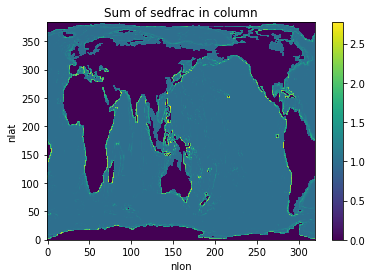

In [10]:
sedfrac_mod = xr.where((land_adjacent==1.) & (sedfrac < land_adj_sedfrac_min), 
                       land_adj_sedfrac_min, sedfrac)

sedfrac_mod = sedfrac_mod.transpose('z_t', 'nlat', 'nlon')
sedfrac_mod = sedfrac_mod.where(MASK==1.).fillna(0.)
sedfrac_mod.sum('z_t').plot()
h = plt.title('Sum of sedfrac in column')

## Compute `fesedflux_reduce`

### Prepare `POC_flux`: 
- convert units
- Where `POC_flux < POC_flux_gCm2yr_min, POC_flux = 0.`; 
- Where `POC_flux > POC_flux_gCm2yr_max, POC_flux = POC_flux_gCm2yr_max`

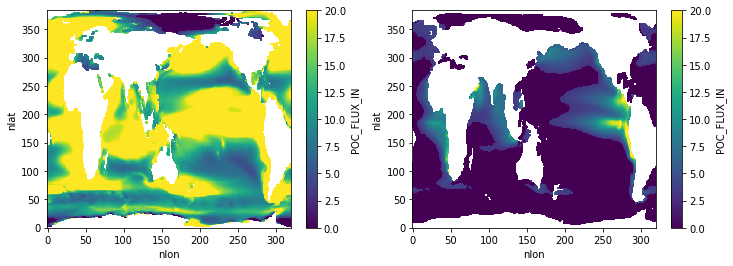

In [11]:
POC_flux = ds.POC_FLUX_IN * nmolCcm2s_to_gCm2yr
POC_flux = xr.where(POC_flux <= POC_flux_gCm2yr_min, 0., POC_flux)
POC_flux = xr.where(POC_flux > POC_flux_gCm2yr_max, POC_flux_gCm2yr_max, POC_flux)
POC_flux = POC_flux.reset_index('z_t', drop=True)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
h = POC_flux.isel(z_t=3).plot()

ax = fig.add_subplot(1, 2, 2)
h = POC_flux.isel(z_t=-20).plot()

### Compute `fesedflux_reduce`

Compute and apply ad hoc scaling in to select regions

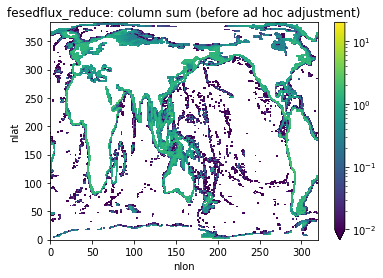

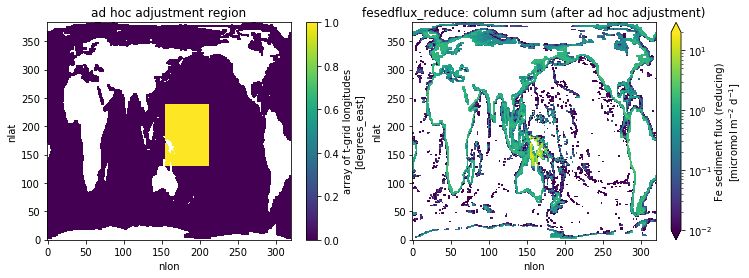

In [12]:
# initial computation
fesedflux_reduce = coef_fesedflux_POC_flux * POC_flux * sedfrac_mod
fesedflux_reduce = fesedflux_reduce.fillna(0.)

fesedflux_reduce = fesedflux_reduce * mmolm2yr_to_µmolm2d

# plot initial values
plt.figure()
fesedflux_reduce.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))
h = plt.title('fesedflux_reduce: column sum (before ad hoc adjustment)')

# apply ad hoc adjustments
region_def = ((134. <= ds.TLONG) & (ds.TLONG <= 200) 
              & (np.fabs(ds.TLAT) <= 15) & (ds.z_t <= 450e2))

region_def = region_def.where(ds.KMT > 0).reset_index('z_t', drop=True)
region_def = region_def.transpose('z_t', 'nlat', 'nlon')

fesedflux_reduce = xr.where(region_def==1, fesedflux_reduce * western_pacific_factor, fesedflux_reduce)
fesedflux_reduce.name = 'Fe sediment flux (reducing)'
fesedflux_reduce.attrs['units'] = 'micromol m$^{-2}$ d$^{-1}$'


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
region_def.isel(z_t=0).plot()
h = plt.title('ad hoc adjustment region')

ax = fig.add_subplot(1, 2, 2)
fesedflux_reduce.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))
h = plt.title('fesedflux_reduce: column sum (after ad hoc adjustment)')

### Report global integral 

In [13]:
fesedflux_reduce_global = esmlab.statistics.weighted_sum(fesedflux_reduce, weights=ds.TAREA/cm2_per_m2, 
                                                         dim=('nlat', 'nlon')).sum('z_t')

fesedflux_reduce_global = fesedflux_reduce_global * mol_per_µmol / mol_per_Gmol * d_per_yr
print(f'Global integral of `fesedflux_reduce_global` = {fesedflux_reduce_global.values:0.4f} Gmol Fe/yr')


Global integral of `fesedflux_reduce_global` = 21.7444 Gmol Fe/yr


## Compute `fesedflux_oxic`

- Read `UVEL` and `VVEL` and compute `current_speed`
- Where `current_speed < current_speed_min: current_speed = current_speed_min`
- Where `current_speed > current_speed_max: current_speed = current_speed_max` 
- `fesedflux_oxic = coef_fesedflux_current_speed2 * sedfrac * current_speed**2`

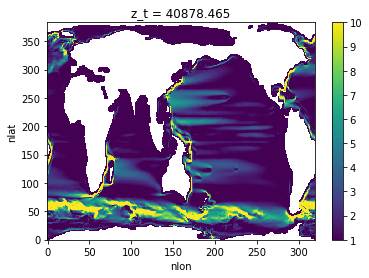

In [14]:
current_speed = np.sqrt(ds.UVEL**2 + ds.VVEL**2)
current_speed = xr.where(current_speed < current_speed_min, current_speed_min, current_speed)
current_speed = xr.where(current_speed > 10., current_speed_max, current_speed)
h = current_speed.isel(z_t=30).plot()

current_speed = current_speed.reset_index('z_t', drop=True)

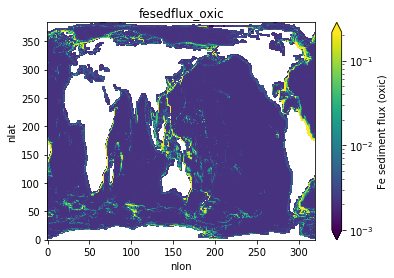

In [15]:
fesedflux_oxic = coef_fesedflux_current_speed2 * sedfrac_mod * current_speed**2
fesedflux_oxic = fesedflux_oxic * mmolm2yr_to_μmolm2d
fesedflux_oxic.name = 'Fe sediment flux (oxic)'
fesedflux_oxic.attrs['units'] = 'micromol m$^{-2}$ d$^{-1}$'
fesedflux_oxic.attrs['long_name'] = 'Fe sediment flux (oxic)'

plt.figure()
fesedflux_oxic.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-3, vmax=fesedflux_oxic.max()))
h = plt.title('fesedflux_oxic')

In [16]:
fesedflux_oxic_global = esmlab.statistics.weighted_sum(fesedflux_oxic, weights=ds.TAREA/cm2_per_m2, 
                                                         dim=('nlat', 'nlon')).sum('z_t')

fesedflux_oxic_global = fesedflux_oxic_global * mol_per_µmol / mol_per_Gmol * d_per_yr
print(f'Global integral of `fesedflux_oxic_global` = {fesedflux_oxic_global.values:0.4f} Gmol Fe/yr')


Global integral of `fesedflux_oxic_global` = 0.9981 Gmol Fe/yr


## Compute total

Global integral of `fesedflux_total_global` = 22.7425 Gmol Fe/yr


/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


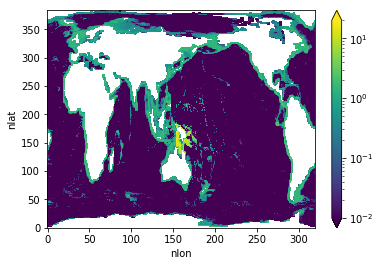

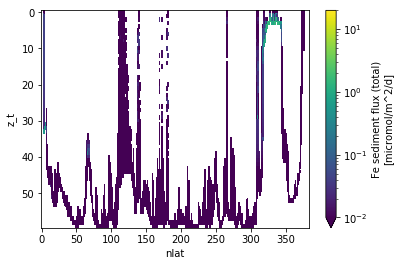

In [17]:
fesedflux_total = (fesedflux_oxic + fesedflux_reduce)
fesedflux_total.attrs['units'] = 'micromol/m^2/d'
fesedflux_total.attrs['long_name'] = 'Fe sediment flux (total)'

fesedflux_total_global = esmlab.statistics.weighted_sum(fesedflux_total, weights=ds.TAREA/cm2_per_m2, 
                                                         dim=('nlat', 'nlon')).sum('z_t')

fesedflux_total_global = fesedflux_total_global * mol_per_µmol / mol_per_Gmol * d_per_yr
print(f'Global integral of `fesedflux_total_global` = {fesedflux_total_global.values:0.4f} Gmol Fe/yr')


plt.figure()
fesedflux_total.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))

plt.figure()
fesedflux_total.isel(nlon=200).plot(yincrease=False, norm=colors.LogNorm(vmin=1e-2, vmax=20.))



## Compare with CESM2 forcing dataset

In [18]:
cesm2_file = f'{config.inputdata}/ocn/pop/gx1v6/forcing/fesedfluxTot_gx1v6_cesm2_2018_c180618.nc'
ds2 = xr.open_dataset(cesm2_file)

ds2['AREA_m2'] = ds.TAREA.rename({'nlat': 'y', 'nlon': 'x'}) * 1e-4
ds2.FESEDFLUXIN.attrs['units'] = 'µmol/m^2/d'
ds2

<xarray.Dataset>
Dimensions:      (x: 320, y: 384, z: 60)
Dimensions without coordinates: x, y, z
Data variables:
    FESEDFLUXIN  (z, y, x) float32 ...
    AREA_m2      (y, x) float64 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08

In [19]:
fesedflux_total_cesm2 = esmlab.statistics.weighted_sum(ds2.FESEDFLUXIN, weights=ds2.AREA_m2, 
                                                         dim=('y', 'x')).sum('z')
fesedflux_total_cesm2 = fesedflux_total_cesm2 * mol_per_µmol / mol_per_Gmol * d_per_yr

print(f'Global integral of `fesedflux_total_cesm2` = {fesedflux_total_cesm2.values:0.4f} Gmol Fe/yr')

Global integral of `fesedflux_total_cesm2` = 19.9526 Gmol Fe/yr


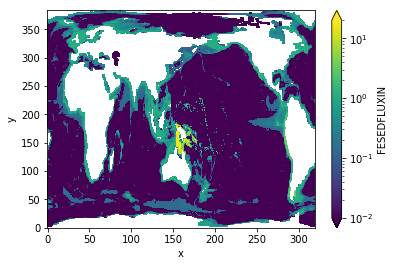

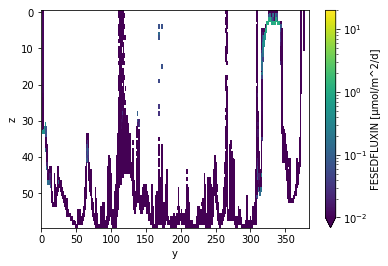

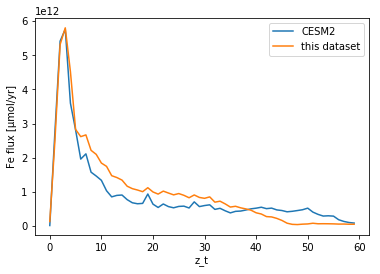

In [20]:
plt.figure()
ds2.FESEDFLUXIN.sum('z').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))

plt.figure()
ds2.FESEDFLUXIN.isel(x=200).plot(yincrease=False, norm=colors.LogNorm(vmin=1e-2, vmax=20.))

plt.figure()
esmlab.statistics.weighted_sum(ds2.FESEDFLUXIN, weights=ds2.AREA_m2, dim=('y', 'x')).plot(label='CESM2')
esmlab.statistics.weighted_sum(fesedflux_total, weights=ds.TAREA/cm2_per_m2, dim=('nlat', 'nlon')).plot(label='this dataset')
plt.ylabel('Fe flux [µmol/yr]')
plt.legend()

## Construct output file

The model uses a scale factor when reading in the `fesedflux`:
`scale_factor = 1.1574e-6`; this converts from µmol/m^2/d to nmol/cm^2/s.

In [21]:
dso = xr.Dataset()

dso['FESEDFLUXIN'] = fesedflux_total
dso.FESEDFLUXIN.encoding = {'_FillValue': None, 'dtype': np.single}

dso['FESEDFLUXIN_reduce'] = fesedflux_reduce
dso.FESEDFLUXIN_reduce.encoding = {'_FillValue': None, 'dtype': np.single}

dso['FESEDFLUXIN_oxic'] = fesedflux_oxic
dso.FESEDFLUXIN_oxic.encoding = {'_FillValue': None, 'dtype': np.single}

for v in ['TAREA', 'TLONG', 'TLAT', 'KMT', 'z_t']:
    dso[v] = ds[v]
    dso.encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by {id_string} on {datestamp}'
dso.attrs['input_file_list'] = ' '.join(input_file_list)

datestamp = date.today().strftime("%y%m%d")
file_out = f'{config.dirout}/fesedflux_total_reduce_oxic_{dst_grid}.c{datestamp}.nc'
dso.to_netcdf(file_out)